In [ ]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from wordcloud import WordCloud
from itertools import islice
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import re
import os

import torch
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from stopwords import STOPWORDS_RU

CURSE_WORDS = []
with open(os.path.join(os.getcwd(), 'curse.txt'), 'r') as f:
    CURSE_WORDS.append(f.read())
CURSE_WORDS = CURSE_WORDS[0].replace('\n\n', ' ')
CURSE_WORDS = CURSE_WORDS.split(' ')

DetectorFactory.seed = 42

 ## Начало анализа
 Первым делом хотелось бы понять как распределены отзывы по оценкам, также пока уберём инфу про название и описание фильмов

In [3]:
data_path = 'mustapp_reviews_total.csv'
extra_columns = ['Title', 'Description']

raw_must_dataset = pd.read_csv(data_path)
reviews_dataset = raw_must_dataset.drop(extra_columns, axis=1)
display(reviews_dataset)

,Mustapp page ID,Review text,Score (out of 10)
0,1,Фильм показывает нестабильную среду простых л...,8
1,1,Простые люди попадают в непростые обстоятельст...,8
2,2,В Финляндии более мрачные Патерсоны\n,7
3,2,Minimalistic with words but still full of mean...,8
4,2,"Просто, приземленно, обыденно, заурядно и имен...",8
...,...,...,...
177505,19992,jodete ledinapoporu te quiero \n,8
177506,19992,Todas las peliculas de doraemon son buenas lo ...,10
177507,19997,"It's good, but could be better...\n",7
177508,19997,Cute ‘95 chick flick. I love Whitney Houstonnn...,5


In [4]:
missing_values = reviews_dataset.isnull().sum()
duplicates = reviews_dataset.duplicated()

for col, count in missing_values.items():
  if count: print(f'В переменной {col} {count} пропущенных значений')
print(f'Всего дубликатов {duplicates.value_counts().iloc[1]}')

# df_train = reviews_dataset.drop_duplicates(subset=reviews_dataset.columns.difference(['selling_price']), keep='first')
reviews = reviews_dataset.drop_duplicates(keep='first')
reviews = reviews.reset_index(drop=True)
display(reviews.tail())

Всего дубликатов 529


,Mustapp page ID,Review text,Score (out of 10)
176976,19992,jodete ledinapoporu te quiero \n,8
176977,19992,Todas las peliculas de doraemon son buenas lo ...,10
176978,19997,"It's good, but could be better...\n",7
176979,19997,Cute ‘95 chick flick. I love Whitney Houstonnn...,5
176980,20000,1989\n,7


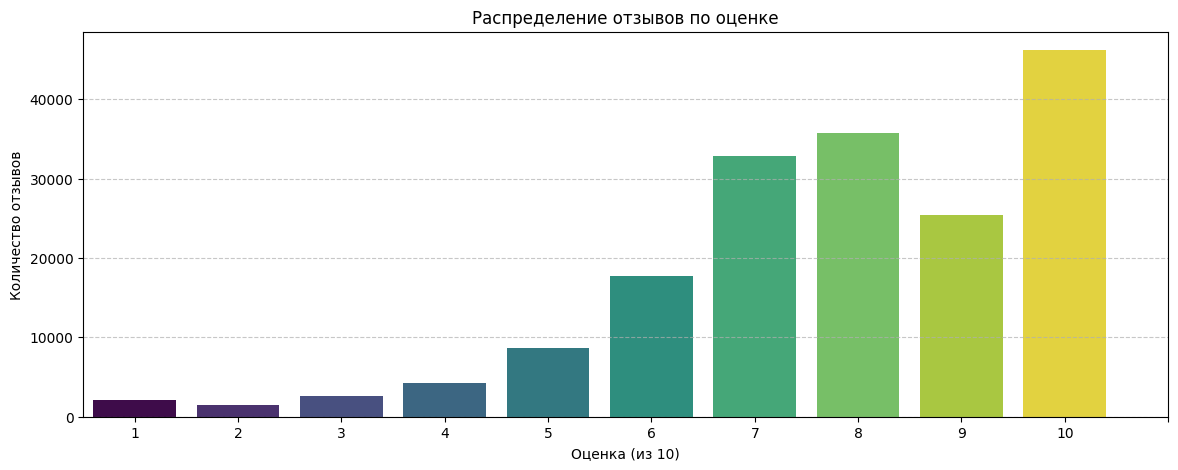

In [5]:
plt.figure(figsize=(14, 5))
sns.countplot(x=reviews['Score (out of 10)'], palette='viridis', hue=reviews['Score (out of 10)'], legend=False)
plt.title('Распределение отзывов по оценке')
plt.xlabel('Оценка (из 10)')
plt.ylabel('Количество отзывов')
plt.xticks(range(0, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Хотелось бы избавиться от сильного выброса положительных отзывов

Наш коллега Даня уже прекрасно справился с этой проблемой путём выбора сабсета положительных отзывов, но я пока воздержусь и буду анализировать весь датасет, так как пока непонятно с какими языками мы будем работать

Аналогично вышеупомянутому мужчине, мы посмотрим на взаимосвязь длины отзыва и оценки

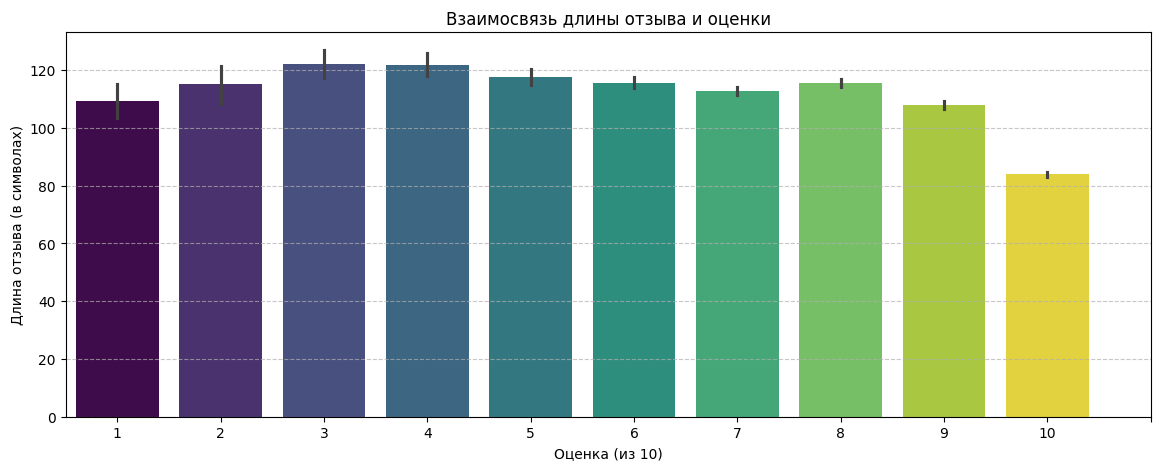

In [6]:
reviews['Review length'] = reviews['Review text'].apply(len)

plt.figure(figsize=(14, 5))
sns.barplot(x=reviews['Score (out of 10)'], y=reviews['Review length'], palette='viridis', hue=reviews['Score (out of 10)'], legend=False)
plt.title('Взаимосвязь длины отзыва и оценки')
plt.xlabel('Оценка (из 10)')
plt.ylabel('Длина отзыва (в символах)')
plt.xticks(range(0, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Как и ожидалось, в среднем отрицательные отзывы будут побольше

Давайте временно решим языковую проблему не самым умным, но статистически полезным образом – добавим в датасет колонку с количеством русских букв в отзыве и построим график, чтобы посмотреть, в скольких отзывах встречается хотя бы одна русская буква

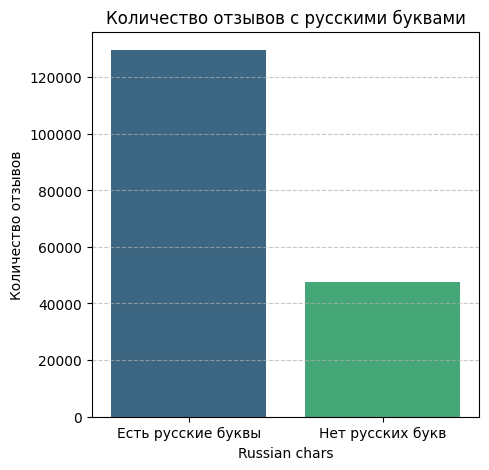

In [7]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

reviews['Russian chars'] = reviews['Review text'].apply(count_russian_chars)

reviews_russian = reviews['Russian chars'] > 0
counts = reviews_russian.value_counts()

# display(counts)

plt.figure(figsize=(5, 5))
sns.barplot(x=counts.index.astype(str), y=counts.values, palette='viridis', hue=counts.index.astype(str), legend=False)
plt.xticks(ticks=[0, 1], labels=['Есть русские буквы', 'Нет русских букв'])
plt.ylabel('Количество отзывов')
plt.title('Количество отзывов с русскими буквами')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Нормально так богатыри захватили must заморский

Мы упоминали, что может быть будущая модель будет давать бинарный результат — давайте на это тоже посмотрим, выкинем оценки 5-6, кажется, без них всё точно логично поделится

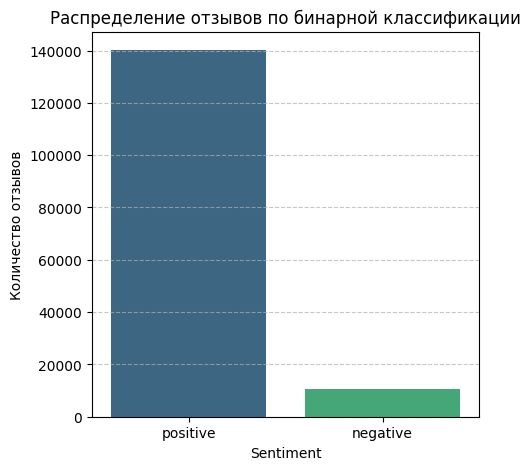

In [8]:
reviews['Sentiment'] = reviews['Score (out of 10)'].apply(lambda x: 'positive' if x >= 7 else ('negative' if x <= 4 else None))
reviews_bin = reviews.dropna(subset=['Sentiment'])
sentiment_counts = reviews_bin['Sentiment'].value_counts()

# display(sentiment_counts)

plt.figure(figsize=(5, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis', hue=sentiment_counts.index, legend=False)
plt.ylabel('Количество отзывов')
plt.title('Распределение отзывов по бинарной классификации')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Похоже в будущем чистить и балансировать датасет мы будем довольно смело

## Языковой барьер
Мы умеем гуглить и пользоваться гпт, поэтому знаем, что с помощью модуля `langdetect` без проблем определим языки отзывов, хоть это и не детерминированное решение, но зато хорошо работает на небольших текстах (по словам разраба), короткие отзывы могут показывать странные результаты, но мы их потом всё равно выкинем во время препроцессинга

In [9]:
# ЯДЕРКА НА 11 МИНУТ
def detect_language(s):
    try:
        return detect(s)
    except LangDetectException:
        return 'Unknown'
    
reviews['Language'] = reviews['Review text'].apply(detect_language)

KeyboardInterrupt: 

Выкинем все неизвестные и посмотрим на топ 10

In [ ]:
reviews_lang = reviews[reviews['Language'] != 'Unknown']
reviews_lang = reviews_lang.reset_index(drop=True)
language_counts = reviews_lang['Language'].value_counts()

display(reviews_lang)
display(language_counts)

,Mustapp page ID,Review text,Score (out of 10),Review length,Russian chars,Sentiment,Language
0,1,Фильм показывает нестабильную среду простых л...,8,182,146,Positive,ru
1,1,Простые люди попадают в непростые обстоятельст...,8,235,189,Positive,ru
2,2,В Финляндии более мрачные Патерсоны\n,7,44,31,Positive,ru
3,2,Minimalistic with words but still full of mean...,8,96,0,Positive,en
4,2,"Просто, приземленно, обыденно, заурядно и имен...",8,127,97,Positive,ru
...,...,...,...,...,...,...,...
167500,19980,Réaliste \n,10,18,0,Positive,fr
167501,19992,jodete ledinapoporu te quiero \n,8,39,0,Positive,es
167502,19992,Todas las peliculas de doraemon son buenas lo ...,10,61,0,Positive,es
167503,19997,"It's good, but could be better...\n",7,42,0,Positive,en


Language
ru       115210
en        20214
uk         5120
es         4620
mk         4384
bg         4338
it         3674
fr         1909
pt          677
ro          554
ca          540
de          534
af          486
cy          477
ja          471
so          404
tr          347
th          346
nl          321
tl          290
fa          267
id          259
no          197
ar          192
et          189
sv          176
sk          174
da          165
sl          162
pl          154
hr          119
sw          109
fi           76
hu           57
sq           57
vi           51
cs           42
lt           38
zh-cn        37
lv           23
ko           20
ur           14
el            6
ta            3
kn            1
zh-tw         1
Name: count, dtype: int64

In [69]:
top = 10
if len(language_counts) > top:
    other_count = language_counts.iloc[top:].sum()
    language_counts = language_counts.iloc[:top]
    language_counts['other'] = other_count

display(language_counts)

Language
ru       115210
en        20214
uk         5120
es         4620
mk         4384
bg         4338
it         3674
fr         1909
pt          677
ro          554
other      6805
Name: count, dtype: int64

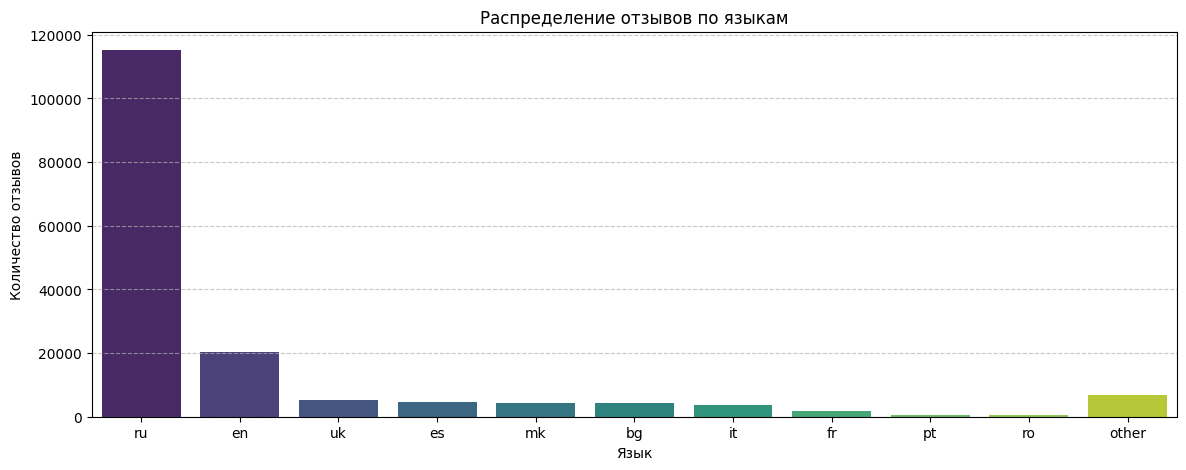

In [72]:
plt.figure(figsize=(14, 5))
sns.barplot(x=language_counts.index, y=language_counts.values, palette='viridis', hue=language_counts.index, legend=False)
plt.xlabel('Язык')
plt.ylabel('Количество отзывов')
plt.title('Распределение отзывов по языкам')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ну как-то очевидно

А что если посмотреть на среднюю/медиану оценки для каждого языка?

In [94]:
lang_stats = reviews_lang.groupby('Language')['Score (out of 10)'].agg(['mean', 'median', 'std', 'count'])

lang_stats_filtered = lang_stats[lang_stats['count'] >= language_counts[top-1]]
# lang_stats_filtered = lang_stats[lang_stats['count'] >= 100]

display(lang_stats_filtered)

/var/folders/jm/7zgk4hp93jgb153vvqrrshrm0000gn/T/ipykernel_14953/3325517904.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lang_stats_filtered = lang_stats[lang_stats['count'] >= language_counts[top-1]]


,mean,median,std,count
Language,,,,
bg,7.778008,8.0,2.123641,4338
en,7.886465,8.0,1.889471,20214
es,7.729437,8.0,1.683034,4620
fr,7.544788,8.0,1.991257,1909
it,7.675014,8.0,1.823999,3674
mk,7.708942,8.0,2.212971,4384
pt,8.268833,9.0,1.933461,677
ro,8.803249,9.0,1.576015,554
ru,7.807942,8.0,1.968759,115210


Не впечатлило, кажется, пришло время брать сабсет данных

Теперь это делать можно смело, так как русских отзывов уж слишком много, ничего не мешает потерять какую-то их часть (конечно, в будущем мы сначала будем выкидывать что-то маленькое по размерам, а уже после думать про всякие сабсеты, но пока пусть будет так)

In [95]:
reviews_lang_10 = reviews_lang[reviews_lang['Score (out of 10)'] == 10].sample(n=3000, random_state=42)
reviews_lang_9 = reviews_lang[reviews_lang['Score (out of 10)'] == 9].sample(n=3000, random_state=42)
reviews_lang_8 = reviews_lang[reviews_lang['Score (out of 10)'] == 8].sample(n=3000, random_state=42)
reviews_lang_7 = reviews_lang[reviews_lang['Score (out of 10)'] == 7].sample(n=3000, random_state=42)
reviews_lang_6 = reviews_lang[reviews_lang['Score (out of 10)'] == 6].sample(n=3000, random_state=42)
reviews_lang_5 = reviews_lang[reviews_lang['Score (out of 10)'] == 5].sample(n=3000, random_state=42)
reviews_lang_others = reviews_lang[reviews_lang['Score (out of 10)'] < 5]
reviews_balanced = pd.concat([reviews_lang_others, reviews_lang_5, reviews_lang_6, reviews_lang_7, reviews_lang_8, reviews_lang_9, reviews_lang_10])

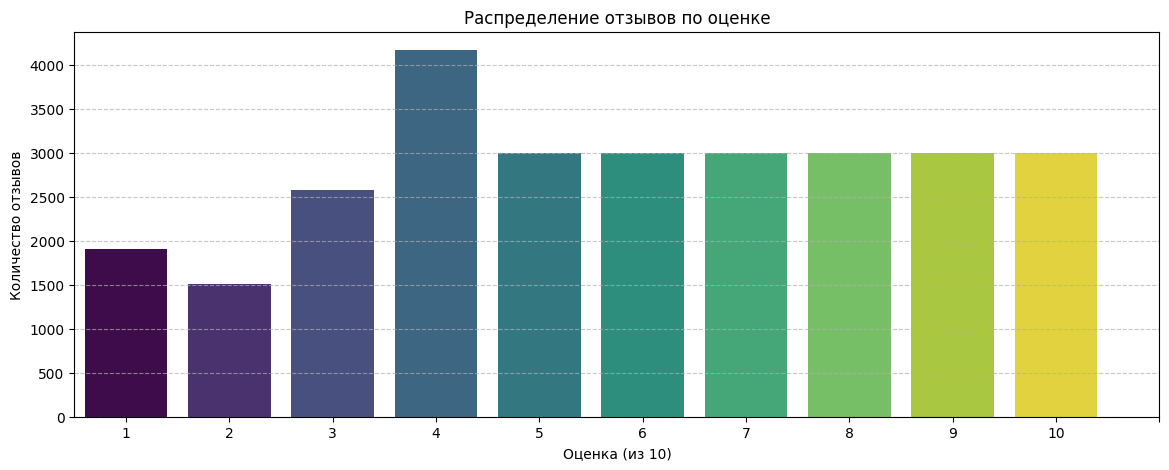

In [96]:
plt.figure(figsize=(14, 5))
sns.countplot(x=reviews_balanced['Score (out of 10)'], palette='viridis', hue=reviews_balanced['Score (out of 10)'], legend=False)
plt.title('Распределение отзывов по оценке')
plt.xlabel('Оценка (из 10)')
plt.ylabel('Количество отзывов')
plt.xticks(range(0, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [97]:
lang_stats = reviews_balanced.groupby('Language')['Score (out of 10)'].agg(['mean', 'median', 'std', 'count'])

lang_stats_filtered = lang_stats[lang_stats['count'] >= language_counts[top-1]]

display(lang_stats_filtered)

/var/folders/jm/7zgk4hp93jgb153vvqrrshrm0000gn/T/ipykernel_14953/270690786.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lang_stats_filtered = lang_stats[lang_stats['count'] >= language_counts[top-1]]


,mean,median,std,count
Language,,,,
bg,5.416667,5.0,2.795602,744
en,5.993258,6.0,2.634596,3263
es,6.432961,7.0,2.456839,716
it,5.775801,6.0,2.590174,562
mk,5.275820,5.0,2.775542,823
ru,5.817676,6.0,2.689020,19575
uk,5.829670,6.0,2.716247,910


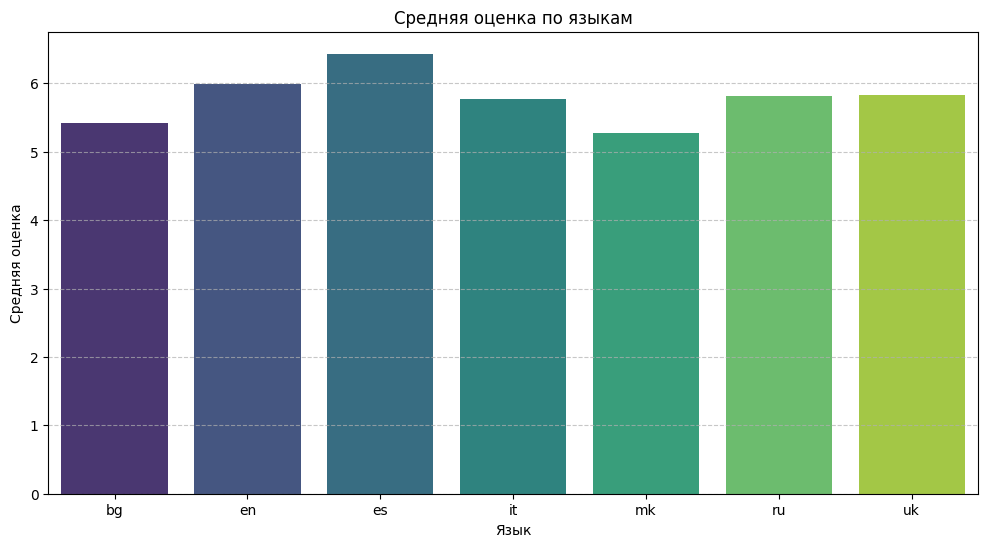

In [98]:
plt.figure(figsize=(12, 6))
sns.barplot(x=lang_stats_filtered.index, y=lang_stats_filtered['mean'], palette='viridis', hue=lang_stats_filtered.index, legend=False)
plt.xlabel('Язык')
plt.ylabel('Средняя оценка')
plt.title('Средняя оценка по языкам')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

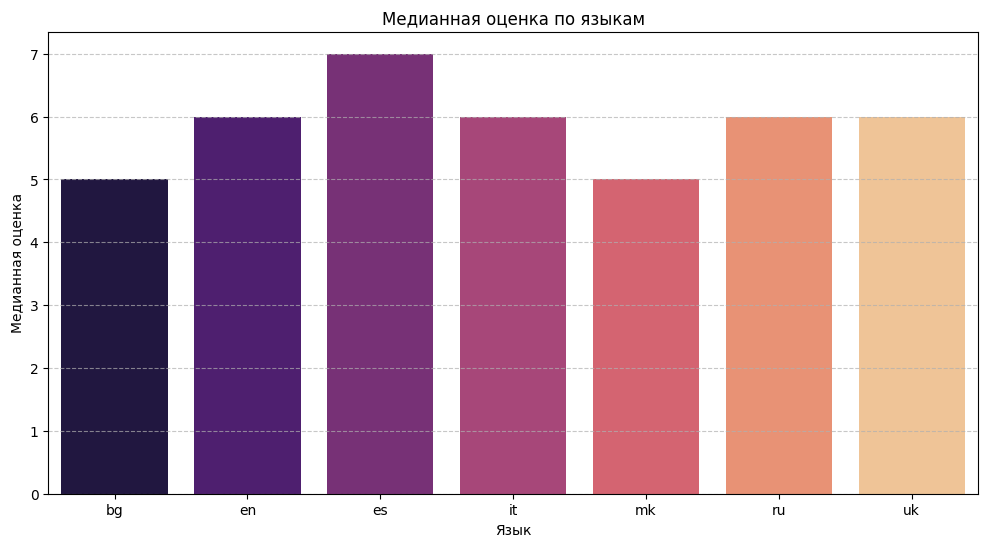

In [99]:
plt.figure(figsize=(12, 6))
sns.barplot(x=lang_stats_filtered.index, y=lang_stats_filtered['median'], palette='magma', hue=lang_stats_filtered.index, legend=False)
plt.xlabel('Язык')
plt.ylabel('Медианная оценка')
plt.title('Медианная оценка по языкам')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Было бы побольше разнообразия языков и оценок в выборке, ситуация была бы нагляднее, но из-за маленького количества отрицательных отзывов что-то сильно полезное отсюда не вытащить

Разве что — Испанцы, статистически, впечатлительнее

В одном из блоков кода сверху есть закомментированная версия инициализации `lang_stats_filtered` и это не просто так, если хратить в ней статы для всех языков, у которых есть хотя бы 100 отзывов, то можно увидеть достаточно похожую на реальность картиру (по крайней мере, мне как пользователю часто доводиться видеть такое) — много кто ставит 8 (даже не 9 и 10)

## Текстовый анализ

Раз уж в датасете много русских отзывов, то посмотрим как у них обстоят дела с популярными словами и ещё некоторыми приколами

In [76]:
russian_reviews = reviews[reviews['Russian chars'] > 0]
positive_reviews = russian_reviews[russian_reviews['Score (out of 10)'] >= 7]['Review text']
negative_reviews = russian_reviews[russian_reviews['Score (out of 10)'] <= 4]['Review text']

def censor_word(word):
    return word[0] + '*' * (len(word) - 2) + word[-1] if len(word) > 2 else word

def censor_text(text):
    return censor_word(text) if text in CURSE_WORDS else text

def extract_ru_words(text):
    words = re.findall(r'\b[а-яА-ЯёЁ]{5,}\b', text.lower())
    return [word for word in words if word not in STOPWORDS_RU]

positive_words = Counter(censor_text(word) for review in positive_reviews for word in extract_ru_words(review))
negative_words = Counter(censor_text(word) for review in negative_reviews for word in extract_ru_words(review))

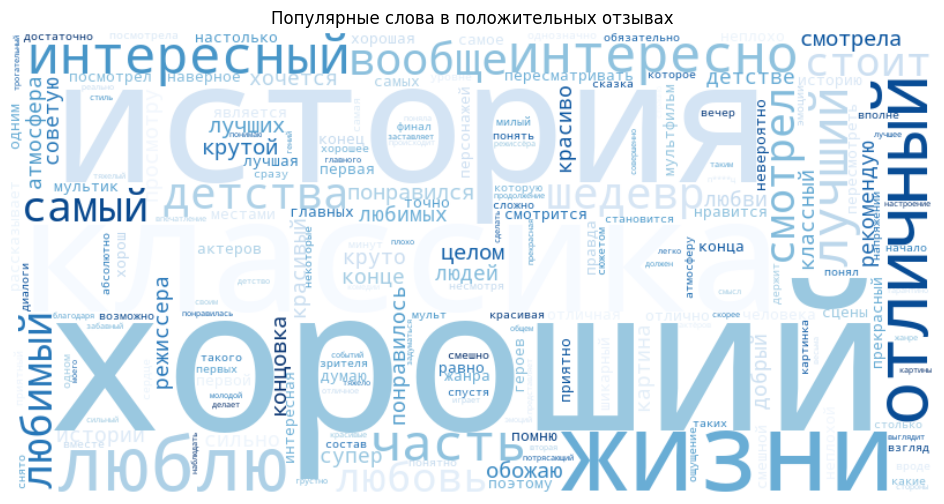

In [77]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues', stopwords=STOPWORDS_RU).generate_from_frequencies(positive_words)
plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Популярные слова в положительных отзывах')
plt.show()

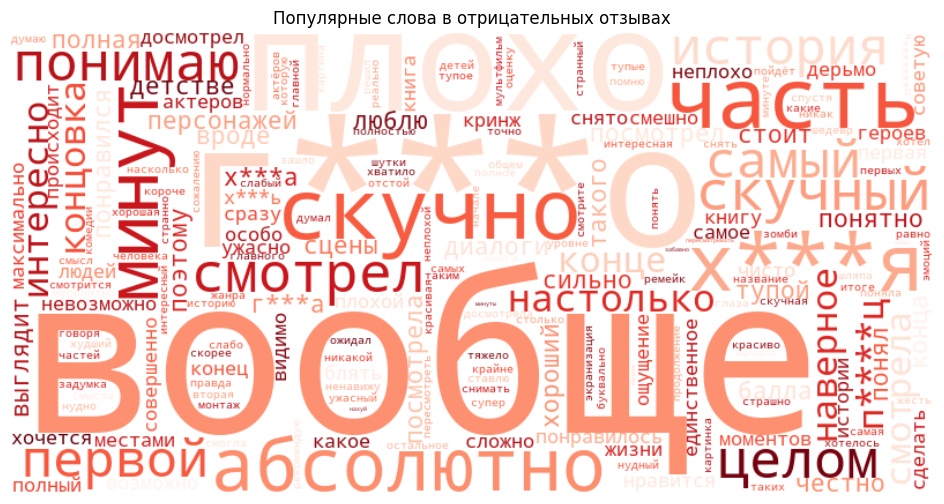

In [78]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(negative_words)
plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Популярные слова в отрицательных отзывах')
plt.show()

In [13]:
emoji_pattern = re.compile(
    '['
    '\U0001F600-\U0001F64F'  # смайлики
    '\U0001F300-\U0001F5FF'  # символы и пиктограммы
    '\U0001F680-\U0001F6FF'  # транспорт и символы карт
    '\U0001F700-\U0001F77F'  # различные символы
    '\U0001F780-\U0001F7FF'  # геометрические символы
    '\U0001F800-\U0001F8FF'  # дополнительные символы
    '\U0001F900-\U0001F9FF'  # дополненные символы
    '\U0001FA00-\U0001FA6F'  # символы жестов
    '\U0001FA70-\U0001FAFF'  # дополнительные символы
    '\U00002702-\U000027B0'  # различные символы
    '\U000024C2-\U0001F251'  # буквы в квадратах
    ']+', flags=re.UNICODE)

def extract_emojis(text):
    return emoji_pattern.findall(text)

positive_emojis = Counter(emoji for review in positive_reviews for emoji in extract_emojis(review))
negative_emojis = Counter(emoji for review in negative_reviews for emoji in extract_emojis(review))

/Users/artem/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/artem/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/artem/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/artem/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129392 (\N{SMILING FACE WITH SMILING EYES AND THREE HEARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/artem/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127995 (\N{EMOJI M

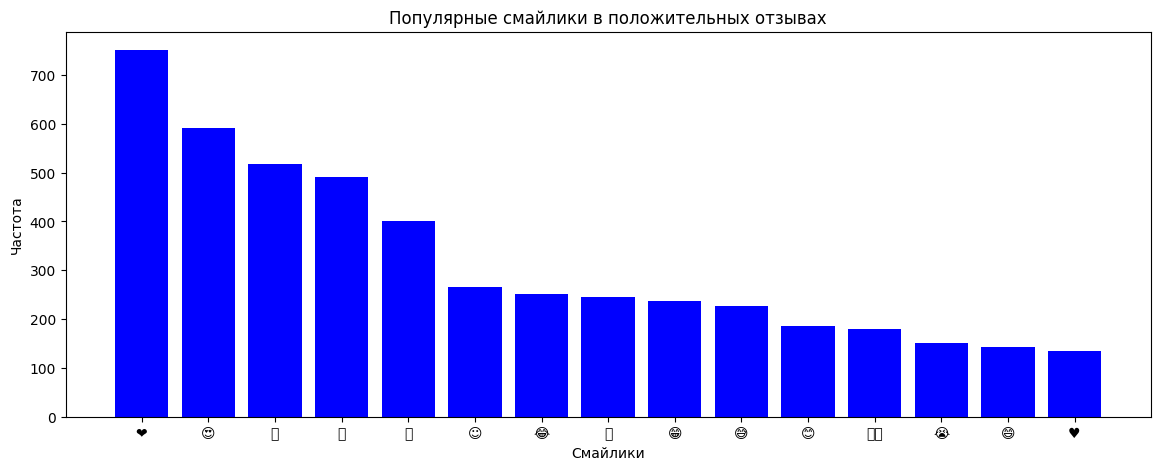

In [14]:
emojis, counts = zip(*positive_emojis.most_common(15))
plt.figure(figsize=(14, 5))
plt.bar(emojis, counts, color='blue')
plt.xlabel('Смайлики',)
plt.ylabel('Частота')
plt.title('Популярные смайлики в положительных отзывах')
plt.show()

/Users/artem/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129314 (\N{NAUSEATED FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/artem/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129318 (\N{FACE PALM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/artem/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129396 (\N{FACE WITH UNEVEN EYES AND WAVY MOUTH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/artem/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128169 (\N{PILE OF POO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/artem/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129300 (\N{THINKING FACE}

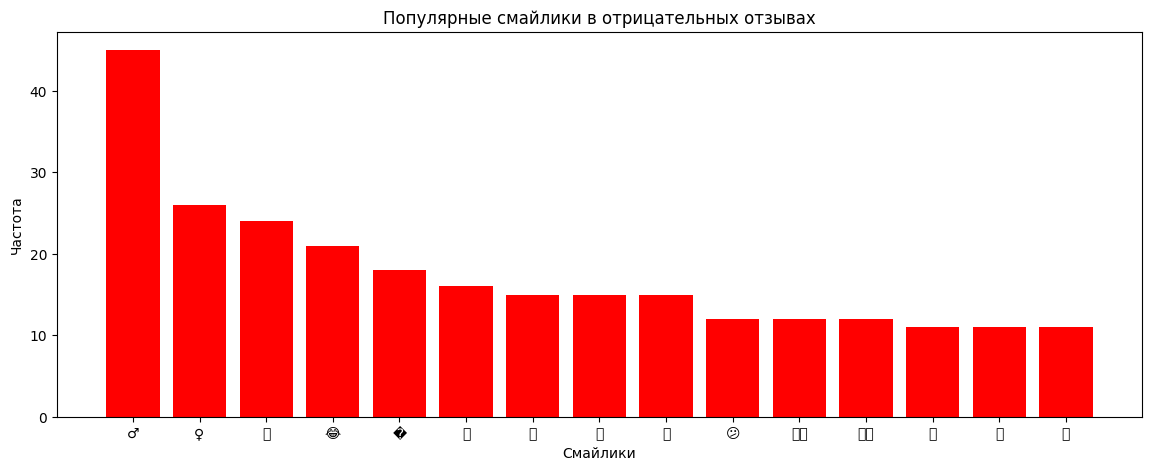

In [15]:
emojis, counts = zip(*negative_emojis.most_common(15))
plt.figure(figsize=(14, 5))
plt.bar(emojis, counts, color='red')
plt.xlabel('Смайлики')
plt.ylabel('Частота')
plt.title('Популярные смайлики в отрицательных отзывах')
plt.show()

Не разобрался с отображением смайликов, но зачем, если в ворнингах всё пишут :)

Посмотри как обстоят дела с популярными фразами

In [79]:
def get_ngrams(text, n):
    words = [censor_text(word) for word in re.findall(r'\b[а-яА-ЯёЁ]{3,}\b', text.lower()) if word not in STOPWORDS_RU]
    return list(zip(*[islice(words, i, None) for i in range(n)]))

def count_ngrams(reviews, n):
    ngram_counter = Counter()
    for review in reviews:
        ngram_counter.update(get_ngrams(review, n))
    return ngram_counter

positive_bigrams = count_ngrams(positive_reviews, 2)
negative_bigrams = count_ngrams(negative_reviews, 2)
positive_trigrams = count_ngrams(positive_reviews, 3)
negative_trigrams = count_ngrams(negative_reviews, 3)

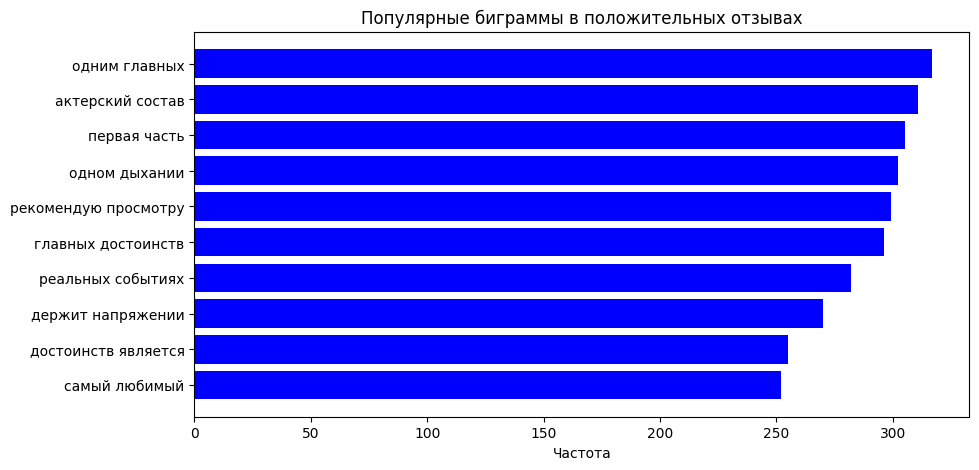

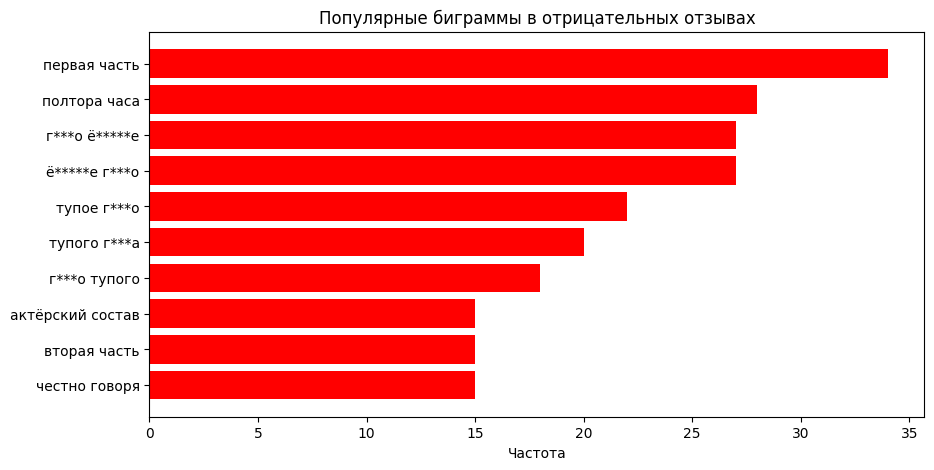

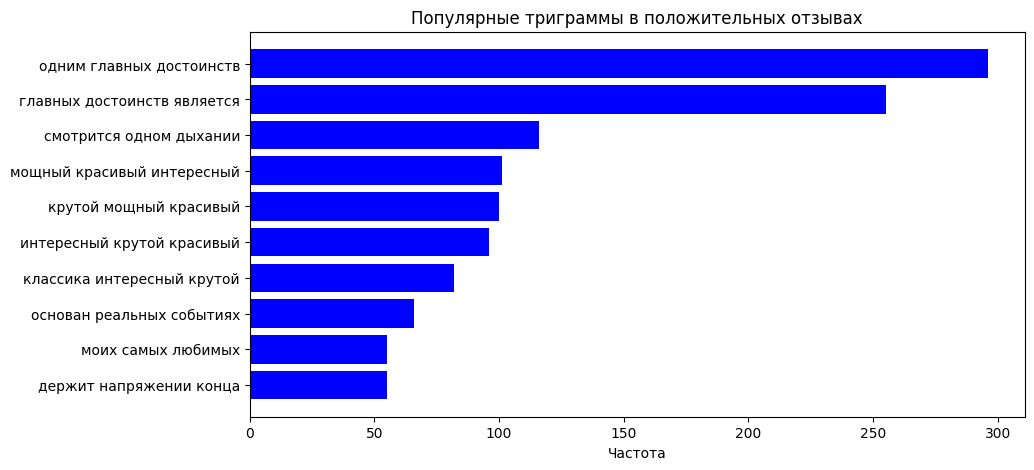

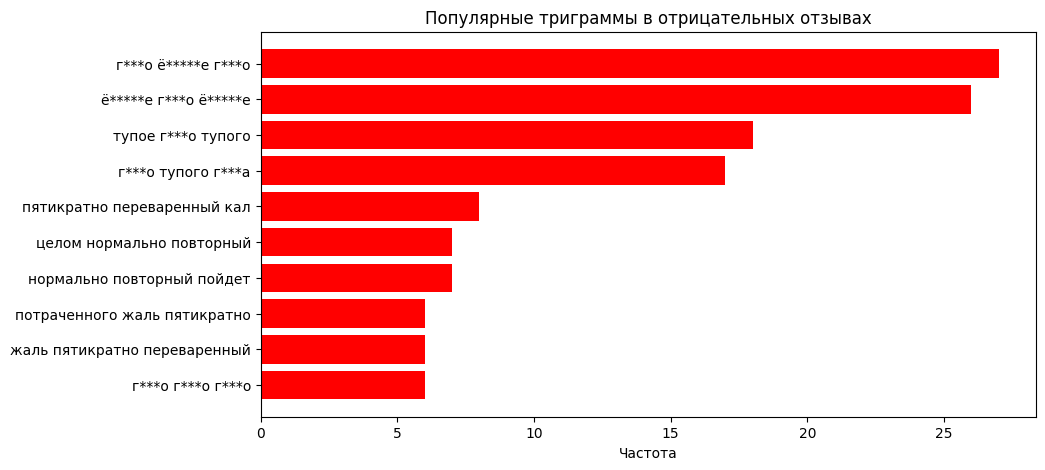

In [80]:
def plot_top_ngrams(ngram_counter, title, color, top_n=10):
    if not ngram_counter:
        print(f'Нет данных для {title}')
        return

    ngrams, counts = zip(*ngram_counter.most_common(top_n))
    ngrams = [' '.join(ngram) for ngram in ngrams]

    plt.figure(figsize=(10, 5))
    plt.barh(ngrams[::-1], counts[::-1], color=color)
    plt.xlabel('Частота')
    plt.title(title)
    plt.show()

plot_top_ngrams(positive_bigrams, 'Популярные биграммы в положительных отзывах', 'blue')
plot_top_ngrams(negative_bigrams, 'Популярные биграммы в отрицательных отзывах', 'red')
plot_top_ngrams(positive_trigrams, 'Популярные триграммы в положительных отзывах', 'blue')
plot_top_ngrams(negative_trigrams, 'Популярные триграммы в отрицательных отзывах', 'red')

## Анализ выбросов

Посмотрим что происходит в очень больших отзывах

/var/folders/jm/7zgk4hp93jgb153vvqrrshrm0000gn/T/ipykernel_1406/2582320852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  russian_reviews['Outlier'] = (russian_reviews['Review length'] > length_threshold).astype(int)


Количество длинных отзывов: 6458 из 129556 (4.98%)


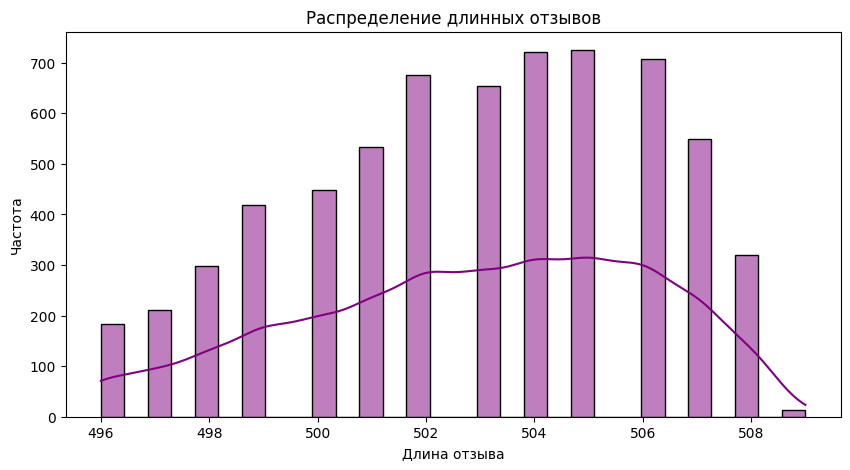

Корреляция между длинными отзывами и оценкой: -0.03


/var/folders/jm/7zgk4hp93jgb153vvqrrshrm0000gn/T/ipykernel_1406/2582320852.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Outlier', y='Score (out of 10)', data=russian_reviews, palette=['orange', 'blue'])


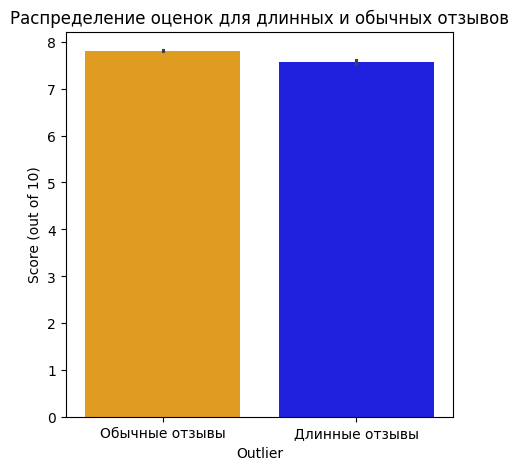

In [18]:
length_threshold = np.percentile(russian_reviews['Review length'], 95)

russian_reviews['Outlier'] = (russian_reviews['Review length'] > length_threshold).astype(int)

outlier_count = russian_reviews['Outlier'].sum()
total_count = len(russian_reviews)
print(f'Количество длинных отзывов: {outlier_count} из {total_count} ({outlier_count/total_count:.2%})')

plt.figure(figsize=(10, 5))
sns.histplot(russian_reviews[russian_reviews['Outlier'] == 1]['Review length'], bins=30, kde=True, color='purple')
plt.title('Распределение длинных отзывов')
plt.xlabel('Длина отзыва')
plt.ylabel('Частота')
plt.show()

corr_outlier_score = russian_reviews[['Outlier', 'Score (out of 10)']].corr().iloc[0, 1]
print(f'Корреляция между длинными отзывами и оценкой: {corr_outlier_score:.2f}')

plt.figure(figsize=(5, 5))
sns.barplot(x='Outlier', y='Score (out of 10)', data=russian_reviews, palette=['orange', 'blue'])
plt.xticks([0, 1], ['Обычные отзывы', 'Длинные отзывы'])
plt.title('Распределение оценок для длинных и обычных отзывов')
plt.show()

## Ну и как там ~~в Египте~~ на hg?

Посмотрим как справляются существующие модели

In [19]:
russian_reviews_bin = russian_reviews[russian_reviews['Sentiment'].notnull()]
display(russian_reviews_bin)
print(russian_reviews_bin['Sentiment'].unique())

,Mustapp page ID,Review text,Score (out of 10),Review length,Russian chars,Sentiment,Outlier
0,1,Фильм показывает нестабильную среду простых л...,8,182,146,positive,0
1,1,Простые люди попадают в непростые обстоятельст...,8,235,189,positive,0
2,2,В Финляндии более мрачные Патерсоны\n,7,44,31,positive,0
4,2,"Просто, приземленно, обыденно, заурядно и имен...",8,127,97,positive,0
5,2,Финны курят 74 minutes straight \n,8,41,10,positive,0
...,...,...,...,...,...,...,...
176968,19954,опять капитализм сосет\n,7,31,20,positive,0
176969,19954,теплое приятное кино об любви подростков-идеал...,9,84,60,positive,0
176970,19955,"Столько эмоций! Это фильм, от которого невозмо...",10,149,110,positive,0
176972,19973,"Странно, что данная экранизация Висконти была ...",9,419,324,positive,0


['positive' 'negative']


In [20]:
model = pipeline(model='seara/rubert-tiny2-russian-sentiment')

def get_sentiment(text):
    prediction = model(text)[0]['label']
    return prediction

russian_reviews_bin_ = russian_reviews_bin.sample(5000, random_state=42)
russian_reviews_bin_['Predicted Sentiment'] = russian_reviews_bin_['Review text'].apply(get_sentiment)

Device set to use cpu


In [21]:
russian_reviews_bin_ = russian_reviews_bin_[russian_reviews_bin_['Predicted Sentiment'] != 'neutral']
display(russian_reviews_bin_)

,Mustapp page ID,Review text,Score (out of 10),Review length,Russian chars,Sentiment,Outlier,Predicted Sentiment
104055,4413,как же я кололась с игры макгрегора…забавный ф...,4,241,185,negative,0,negative
138938,6788,Отличнейший ромком с крутыми отсылками и всяки...,8,100,77,positive,0,positive
140571,6974,Очень хороший фильм. \n,8,30,17,positive,0,positive
7889,72,https://youtu.be/8bukPGph2ec Taxi DriverвЂ™s p...,9,497,2,positive,1,negative
171282,15254,"Что ж, это что-то непохожее на другие фильмы у...",7,131,99,positive,0,negative
...,...,...,...,...,...,...,...,...
116453,5043,"Стандартный фильм Тонни Скотта, не самый лучши...",8,91,66,positive,0,positive
56701,827,пиздец \n,8,16,6,positive,0,negative
84665,2542,"эх, картинка невероятная, но после книги фильм...",7,78,55,positive,0,positive
130955,6108,"Вот всё прекрасно, кроме этих странных музыкал...",9,69,49,positive,0,positive


Accuracy: 0.85
Precision: [0.26059322 0.98417266]
Recall: [0.78846154 0.8546439 ]
F1-score: [0.39171975 0.91484619]


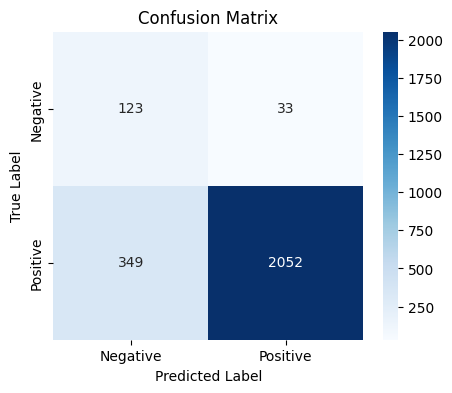

In [22]:
accuracy = accuracy_score(russian_reviews_bin_['Sentiment'], russian_reviews_bin_['Predicted Sentiment'])
precision, recall, f1, _ = precision_recall_fscore_support(russian_reviews_bin_['Sentiment'], russian_reviews_bin_['Predicted Sentiment'])

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

cm = confusion_matrix(russian_reviews_bin_['Sentiment'], russian_reviews_bin_['Predicted Sentiment'])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()